In [12]:
import pandas as pd
from ucimlrepo import fetch_ucirepo
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from scipy.stats import friedmanchisquare
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import category_encoders as ce


In [13]:
adult = fetch_ucirepo(id=2) 
data = adult.data.original
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [14]:
data.dropna(inplace=True)

In [15]:
X = data.drop(columns='income')
y = data['income']

In [16]:
y = y.str.strip().str.replace('.', '', regex=False)
y.unique()

array(['<=50K', '>50K'], dtype=object)

In [17]:
y = y.map({'<=50K': 0, '>50K': 1})

In [18]:
categorical_columns = X.select_dtypes(include=['object']).columns
numeric_columns = X.select_dtypes(exclude=['object']).columns

categorical_transformer = Pipeline(steps=[
    ('target', ce.TargetEncoder())
])

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_columns),
        ('cat', categorical_transformer, categorical_columns)
    ]
)

X_encoded = pd.DataFrame(preprocessor.fit_transform(X, y), columns=numeric_columns.tolist() + preprocessor.named_transformers_['cat'].named_steps['target'].get_feature_names_out().tolist())
X_encoded.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass,education,marital-status,occupation,relationship,race,sex,native-country
0,0.026501,-1.062924,1.132729,0.144629,-0.217456,-0.048943,0.269211,0.415303,0.046416,0.136876,0.102679,0.257074,0.307011,0.247311
1,0.837781,-1.008031,1.132729,-0.145735,-0.217456,-2.251188,0.278530,0.415303,0.448739,0.478376,0.450918,0.257074,0.307011,0.247311
2,-0.047252,0.245517,-0.424726,-0.145735,-0.217456,-0.048943,0.217635,0.160192,0.102053,0.066796,0.102679,0.257074,0.307011,0.247311
3,1.059039,0.426206,-1.203454,-0.145735,-0.217456,-0.048943,0.217635,0.051546,0.448739,0.066796,0.450918,0.122381,0.307011,0.247311
4,-0.784780,1.408394,1.132729,-0.145735,-0.217456,-0.048943,0.217635,0.415303,0.448739,0.450409,0.473591,0.122381,0.110686,0.250000


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=45)

In [20]:
def show_metrics(y_pred, X_test, y_test):
    print('Classification report:')
    report = classification_report(y_test, y_pred, zero_division=1)
    print(report)

    print('Confusion matrix:')
    cm = confusion_matrix(y_test, y_pred)
    print(cm)

Decision Tree

In [21]:
dt = DecisionTreeClassifier(random_state=45)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
y_proba_dt = dt.predict_proba(X_test)[:, 1]

show_metrics(y_pred_dt, X_test, y_test)

Classification report:
              precision    recall  f1-score   support

           0       0.88      0.87      0.88     10838
           1       0.61      0.63      0.62      3449

    accuracy                           0.81     14287
   macro avg       0.75      0.75      0.75     14287
weighted avg       0.82      0.81      0.81     14287

Confusion matrix:
[[9451 1387]
 [1282 2167]]


In [22]:
results_dt = {
    'Accuracy': accuracy_score(y_test, y_pred_dt),
    'Precision': precision_score(y_test, y_pred_dt, average='weighted'),
    'Recall': recall_score(y_test, y_pred_dt, average='weighted'),
    'F1 Score': f1_score(y_test, y_pred_dt, average='weighted'),
    'AUC': roc_auc_score(y_test, y_proba_dt)
}

SVM

In [23]:
svm = SVC(probability=True, random_state=45)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
y_proba_svm = svm.predict_proba(X_test)[:, 1]

show_metrics(y_pred_svm, X_test, y_test)

Classification report:
              precision    recall  f1-score   support

           0       0.86      0.95      0.90     10838
           1       0.77      0.53      0.63      3449

    accuracy                           0.85     14287
   macro avg       0.82      0.74      0.77     14287
weighted avg       0.84      0.85      0.84     14287

Confusion matrix:
[[10295   543]
 [ 1619  1830]]


In [24]:
results_svm = {
    'Accuracy': accuracy_score(y_test, y_pred_svm),
    'Precision': precision_score(y_test, y_pred_svm, average='weighted'),
    'Recall': recall_score(y_test, y_pred_svm, average='weighted'),
    'F1 Score': f1_score(y_test, y_pred_svm, average='weighted'),
    'AUC': roc_auc_score(y_test, y_proba_svm)
}

Redes neurais

In [25]:
nn = MLPClassifier(random_state=45, max_iter=300)
nn.fit(X_train, y_train)
y_pred_nn = nn.predict(X_test)
y_proba_nn = nn.predict_proba(X_test)[:, 1]

show_metrics(y_pred_nn, X_test, y_test)

Classification report:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91     10838
           1       0.77      0.57      0.66      3449

    accuracy                           0.86     14287
   macro avg       0.82      0.76      0.78     14287
weighted avg       0.85      0.86      0.85     14287

Confusion matrix:
[[10247   591]
 [ 1476  1973]]


In [26]:
results_nn = {
    'Accuracy': accuracy_score(y_test, y_pred_nn),
    'Precision': precision_score(y_test, y_pred_nn, average='weighted'),
    'Recall': recall_score(y_test, y_pred_nn, average='weighted'),
    'F1 Score': f1_score(y_test, y_pred_nn, average='weighted'),
    'AUC': roc_auc_score(y_test, y_proba_nn)
}

Random Forest

In [27]:
rf = RandomForestClassifier(random_state=45)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

show_metrics(y_pred_rf, X_test, y_test)

Classification report:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91     10838
           1       0.74      0.63      0.68      3449

    accuracy                           0.86     14287
   macro avg       0.82      0.78      0.80     14287
weighted avg       0.85      0.86      0.85     14287

Confusion matrix:
[[10091   747]
 [ 1270  2179]]


In [28]:
results_rf = {
    'Accuracy': accuracy_score(y_test, y_pred_rf),
    'Precision': precision_score(y_test, y_pred_rf, average='weighted'),
    'Recall': recall_score(y_test, y_pred_rf, average='weighted'),
    'F1 Score': f1_score(y_test, y_pred_rf, average='weighted'),
    'AUC': roc_auc_score(y_test, y_proba_rf)
}

Stacking

In [29]:
stacking = StackingClassifier(
    estimators=[
        ('dt', DecisionTreeClassifier(random_state=45)),
        ('svc', SVC(probability=True, random_state=45)),
        ('mlp', MLPClassifier(random_state=45, max_iter=300)),
        ('rf', RandomForestClassifier(random_state=45))
    ],
    final_estimator=LogisticRegression()
)
stacking.fit(X_train, y_train)
y_pred_stacking = stacking.predict(X_test)
y_proba_stacking = stacking.predict_proba(X_test)[:, 1]

show_metrics(y_pred_stacking, X_test, y_test)

Classification report:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91     10838
           1       0.77      0.60      0.68      3449

    accuracy                           0.86     14287
   macro avg       0.83      0.77      0.79     14287
weighted avg       0.86      0.86      0.86     14287

Confusion matrix:
[[10233   605]
 [ 1373  2076]]


In [30]:
results_stacking = {
    'Accuracy': accuracy_score(y_test, y_pred_stacking),
    'Precision': precision_score(y_test, y_pred_stacking, average='weighted'),
    'Recall': recall_score(y_test, y_pred_stacking, average='weighted'),
    'F1 Score': f1_score(y_test, y_pred_stacking, average='weighted'),
    'AUC': roc_auc_score(y_test, y_proba_stacking)
}


Teste de Fredman

In [31]:
results = {
    'Decision Tree': results_dt,
    'SVM': results_svm,
    'Neural Network': results_nn,
    'Random Forest': results_rf,
    'Stacking': results_stacking
}

results_df = pd.DataFrame(results).T

In [32]:
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC']
friedman_results = {}
for metric in metric_names:
    scores = [results[name][metric] for name in results if results[name][metric] is not None]
    stat, p = friedmanchisquare(*scores)
    friedman_results[metric] = (stat, p)

print("\nFriedman Test Results:")
for metric, (stat, p) in friedman_results.items():
    print(f"{metric}: Statistic={stat:.4f}, p-value={p:.4f}")


Friedman Test Results:
Accuracy: Statistic=4.0000, p-value=0.4060
Precision: Statistic=4.0000, p-value=0.4060
Recall: Statistic=4.0000, p-value=0.4060
F1 Score: Statistic=4.0000, p-value=0.4060
AUC: Statistic=4.0000, p-value=0.4060


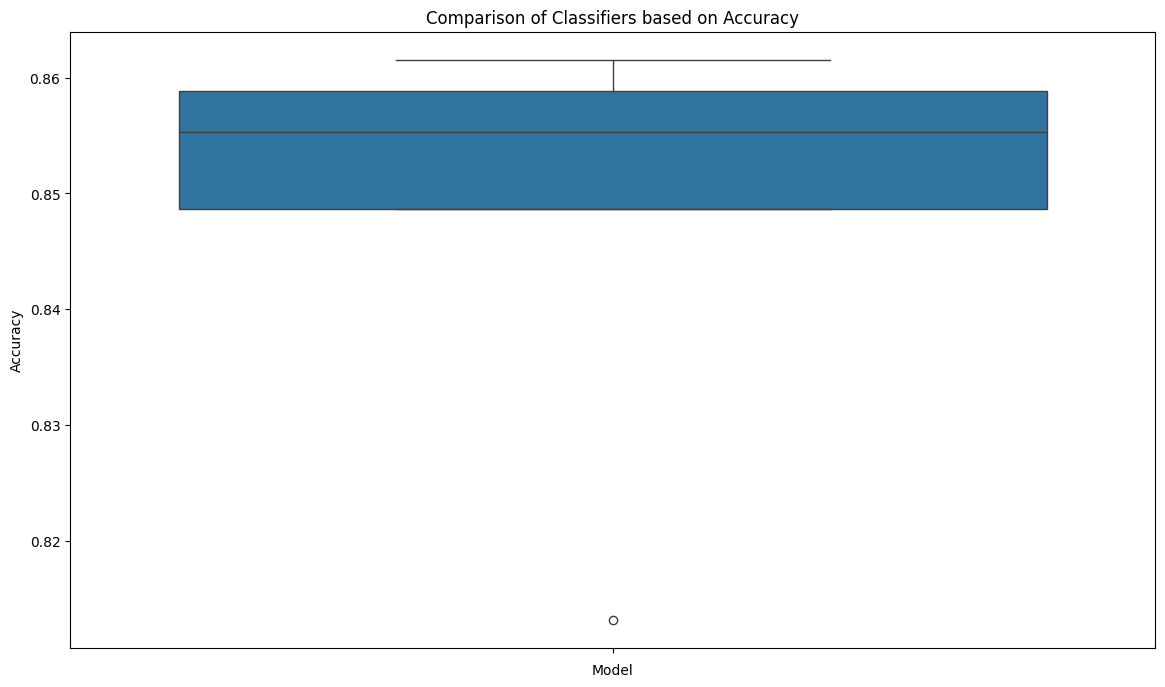

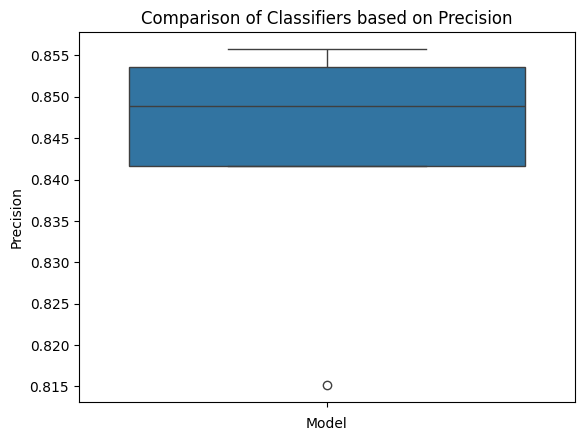

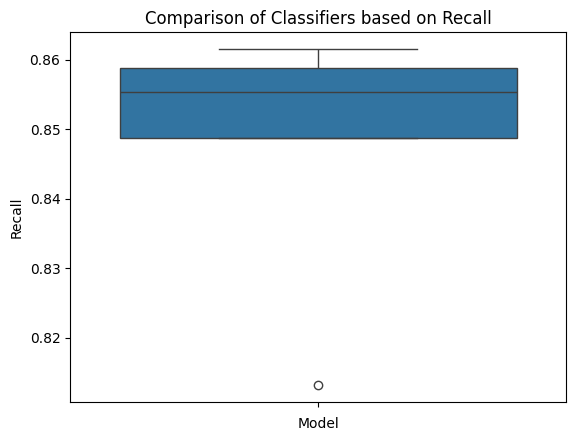

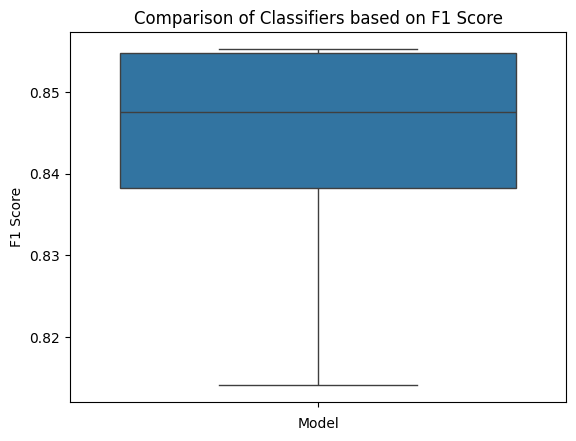

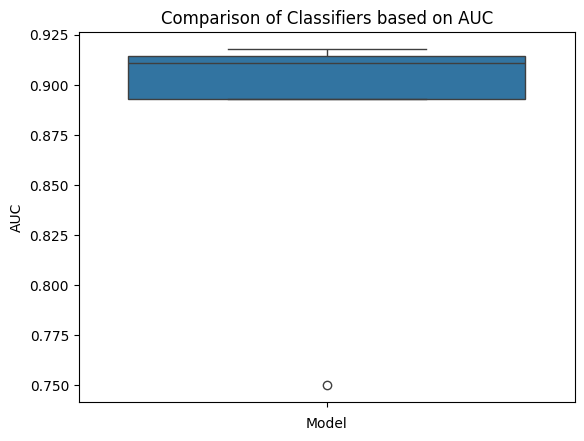

In [33]:
plt.figure(figsize=(14, 8))
for metric in metric_names:
    sn.boxplot(data=results_df[metric].dropna())
    plt.title(f'Comparison of Classifiers based on {metric}')
    plt.xlabel('Model')
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    plt.show()
